# Another round of testing ClusterDE

In [44]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
from scipy.stats import ranksums, spearmanr
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.ClusterDE as cd

import importlib

In [45]:
import os
os.environ['R_HOME'] = '/Library/Frameworks/R.framework/Resources'
r_path = "/Library/Frameworks/R.framework/Resources/bin"
os.environ["PATH"] = r_path + ";" + os.environ["PATH"]

import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


/var/folders/c0/fpqfgc2s7f76rlp41vv8hxy1h1ttxs/T/ipykernel_39550/1064225130.py:7: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [46]:
import importlib

## Preprocessing
### Read data

In [47]:
data_path = "../../data/filtered_gene_bc_matrices/hg19"
adata = sc.read_h5ad(data_path + "/pbmc.h5ad")

sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]
# sc.pp.filter_genes(adata, min_cells=3)
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=200, layer="counts")
adata.raw = adata
adata = adata[:, adata.var.highly_variable]
adata.layers["counts"] = adata.layers["counts"][:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)


/var/folders/c0/fpqfgc2s7f76rlp41vv8hxy1h1ttxs/T/ipykernel_39550/2166695158.py:11: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers["counts"] = adata.X.copy()
/var/folders/c0/fpqfgc2s7f76rlp41vv8hxy1h1ttxs/T/ipykernel_39550/2166695158.py:17: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers["counts"] = adata.layers["counts"][:, adata.var.highly_variable]


/Users/johannes.ostner/opt/anaconda3/envs/BacSC2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/johannes.ostner/opt/anaconda3/envs/BacSC2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


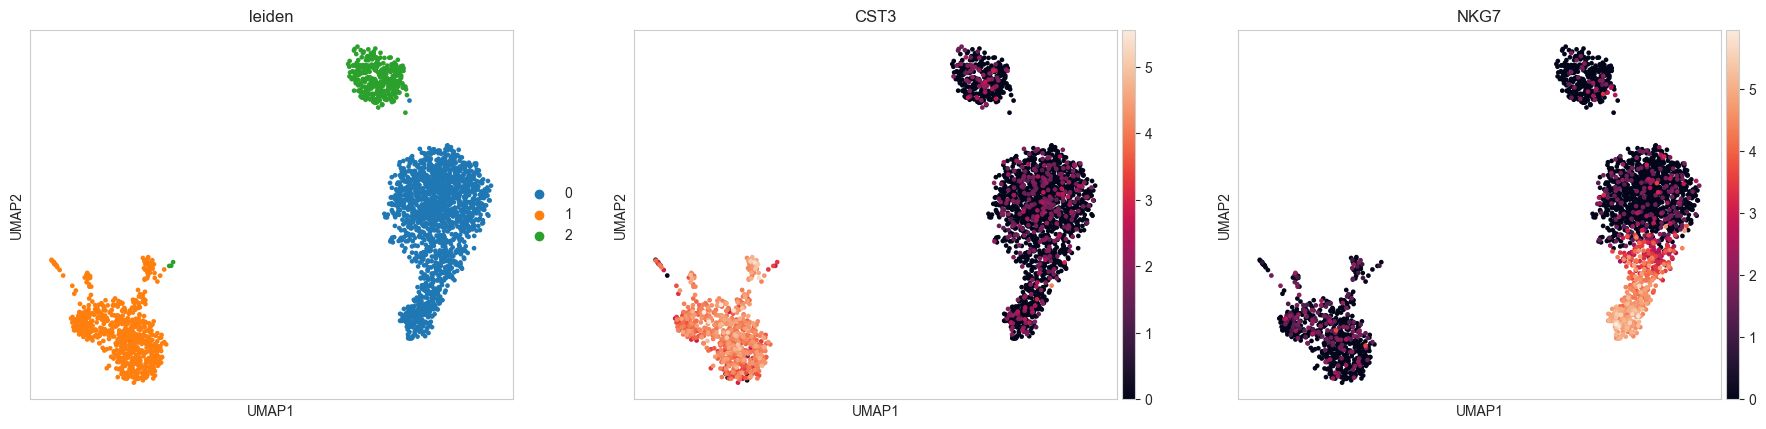

AnnData object with n_obs × n_vars = 2638 × 200
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [48]:
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.1)
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])

adata

/Users/johannes.ostner/opt/anaconda3/envs/BacSC2/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


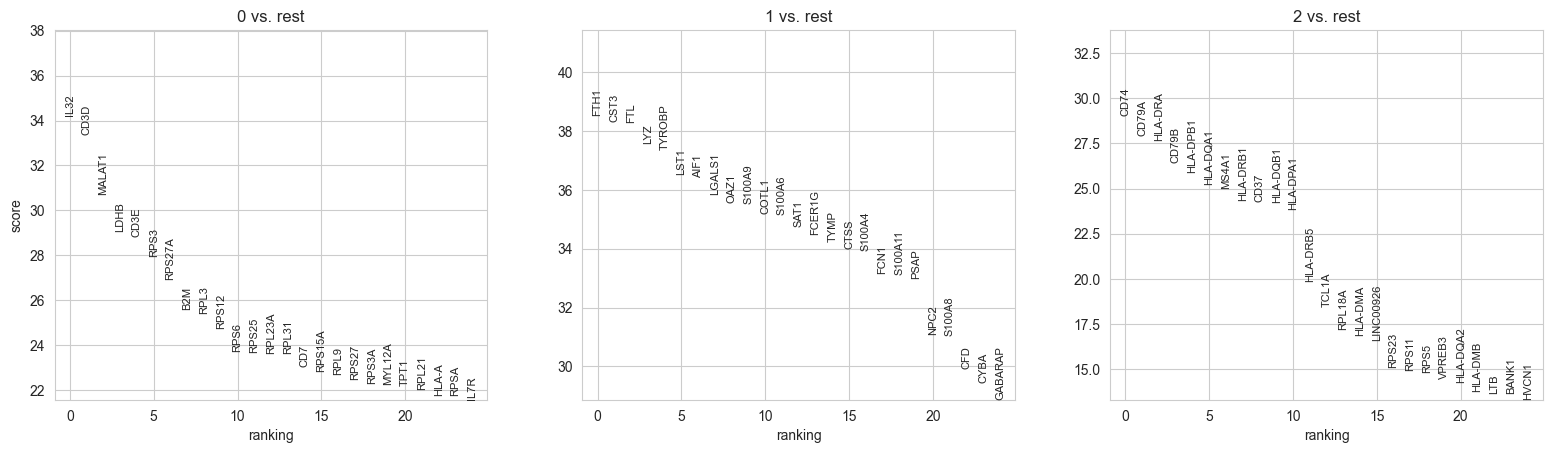

In [49]:
data_gene = adata.copy()
sc.tl.rank_genes_groups(data_gene, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(data_gene, n_genes=25, sharey=False)

In [50]:
sc.pp.calculate_qc_metrics(data_gene, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True, layer="counts")
data_gene.var

,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,highly_variable_rank,means,variances,variances_norm,mean,std
TNFRSF9,11,False,11,0.007961,99.583017,21.0,True,113.0,0.007961,0.027620,2.520457,0.008111,0.131858
SDHB,581,False,571,0.315011,78.354814,831.0,True,61.0,0.315011,3.336073,2.973670,0.367736,0.732621
C1QA,36,False,36,0.043215,98.635330,114.0,True,18.0,0.043215,0.339429,4.459221,0.025365,0.231145
C1QB,17,False,17,0.028810,99.355572,76.0,True,21.0,0.028810,0.269932,4.018014,0.013830,0.180528
STMN1,196,False,190,0.115997,92.797574,306.0,True,109.0,0.115997,0.807169,2.534403,0.132159,0.492745
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ADSL,285,False,279,0.142532,89.423806,376.0,True,163.0,0.142532,1.209863,2.416078,0.176254,0.532029
PACSIN2,121,False,120,0.067854,95.451099,179.0,True,153.0,0.067854,0.666232,2.424775,0.076065,0.367282
DSCR3,171,False,164,0.100076,93.783169,264.0,True,32.0,0.100076,1.235336,3.412178,0.104817,0.430903
C21orf33,289,False,282,0.145565,89.310083,384.0,True,175.0,0.145565,1.355367,2.398396,0.179388,0.539169


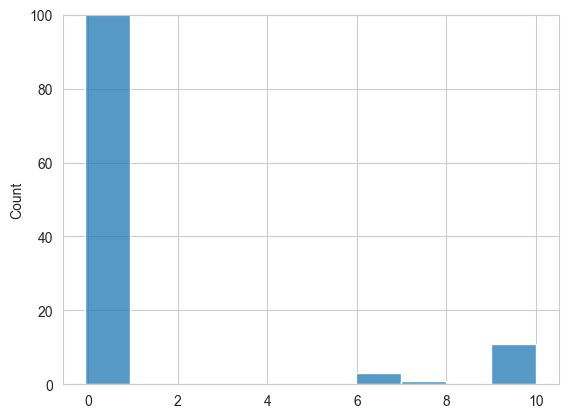

In [51]:
g = sns.histplot(data_gene.X[:, 166], binwidth=1)
g.set(ylim=(0, 100))
plt.show()

In [68]:
importlib.reload(nb)
nb.estimate_overdisp_nb(data_gene, layer="counts", flavor="statsmod_auto", use_init_params=True)


gene 0
gene 100


/Users/johannes.ostner/opt/anaconda3/envs/BacSC2/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:3937: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/Users/johannes.ostner/opt/anaconda3/envs/BacSC2/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:3938: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/Users/johannes.ostner/opt/anaconda3/envs/BacSC2/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/johannes.ostner/opt/anaconda3/envs/BacSC2/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/johannes.ostner/opt/anaconda3/envs/BacSC2/lib/python3.11/site-packages

In [69]:
importlib.reload(cd)
data_null_gen, R_est = cd.generate_nb_data_copula(data_gene, rng_seed=5678, nb_flavor="statsmod_auto", auto_dist=True, correct_var=True, return_R=True, corr_factor=1, R_est=None, check_pd=True)
data_null_gen


AnnData object with n_obs × n_vars = 2638 × 200

In [70]:
sc.pp.calculate_qc_metrics(data_null_gen, percent_top=None)
data_null_gen.var["var_counts"] = np.asarray(np.var(data_null_gen.X, axis=0)).squeeze()
data_null_gen.var["mean_counts"] = np.asarray(np.mean(data_null_gen.X, axis=0)).squeeze()

data_gene.var["var_counts"] = np.asarray(np.var(data_gene.layers["counts"].toarray(), axis=0)).squeeze()
data_gene.var["mean_counts"] = np.asarray(np.mean(data_gene.layers["counts"].toarray(), axis=0)).squeeze()

In [71]:
data_gene.var

,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,highly_variable_rank,means,variances,...,var_counts,pval_cluster_0_gen,q_cluster_0_gen,DE_cluster_0_gen,pval_cluster_2_gen,q_cluster_2_gen,DE_cluster_2_gen,pval_cluster_1_gen,q_cluster_1_gen,DE_cluster_1_gen
TNFRSF9,11,False,11,0.007961,99.583017,21.0,True,113.0,0.007961,0.027620,...,0.027609,8.737929e-01,0.208589,False,0.885611,0.560976,False,9.472878e-01,0.203593,False
SDHB,581,False,571,0.315011,78.354814,831.0,True,61.0,0.315011,3.336073,...,3.334809,1.489900e-07,0.208589,False,0.338135,1.000000,False,4.632065e-11,0.203593,False
C1QA,36,False,36,0.043215,98.635330,114.0,True,18.0,0.043215,0.339429,...,0.339300,1.682525e-01,0.060606,True,0.637772,0.566265,False,5.807573e-02,0.018868,True
C1QB,17,False,17,0.028810,99.355572,76.0,True,21.0,0.028810,0.269932,...,0.269830,5.177321e-01,0.072727,True,0.824057,0.560976,False,3.730952e-01,0.018868,True
STMN1,196,False,190,0.115997,92.797574,306.0,True,109.0,0.115997,0.807169,...,0.806863,3.113330e-02,0.153846,False,0.711651,1.000000,False,7.308530e-03,0.069444,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ADSL,285,False,279,0.142532,89.423806,376.0,True,163.0,0.142532,1.209863,...,1.209404,7.437580e-01,0.208589,False,0.131222,0.208333,False,4.255012e-01,0.018868,True
PACSIN2,121,False,120,0.067854,95.451099,179.0,True,153.0,0.067854,0.666232,...,0.665980,2.459854e-01,0.153846,False,0.645181,1.000000,False,9.997866e-02,0.018868,True
DSCR3,171,False,164,0.100076,93.783169,264.0,True,32.0,0.100076,1.235336,...,1.234867,8.297780e-01,1.000000,False,0.827954,1.000000,False,6.845020e-01,1.000000,False
C21orf33,289,False,282,0.145565,89.310083,384.0,True,175.0,0.145565,1.355367,...,1.354853,9.270650e-01,1.000000,False,0.751916,1.000000,False,8.876853e-01,1.000000,False


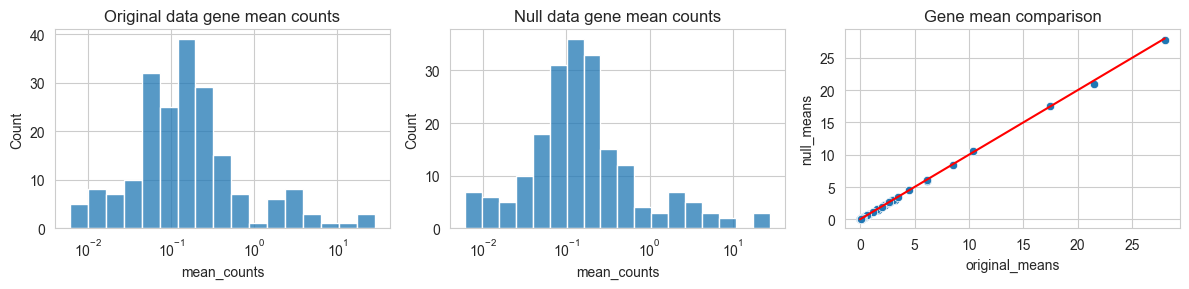

SignificanceResult(statistic=0.9931510830649855, pvalue=1.371082313051248e-186)


In [72]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene.var, x="mean_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene mean counts")
sns.histplot(data_null_gen.var, x="mean_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene mean counts")

mean_df = pd.DataFrame({"original_means": data_gene.var["mean_counts"], "null_means": data_null_gen.var["mean_counts"]})
mean_df["ratio"] = mean_df["null_means"] / mean_df["original_means"]
mean_df["diff"] = mean_df["null_means"] - mean_df["original_means"]

sns.scatterplot(mean_df, y="null_means", x="original_means", ax=ax[2])
ax[2].plot([0, np.ceil(np.max(data_gene.var["mean_counts"]))], [0, np.ceil(np.max(data_gene.var["mean_counts"]))], color="red")
ax[2].set_title("Gene mean comparison")
plt.tight_layout()
plt.show()
print(spearmanr(mean_df["original_means"], mean_df["null_means"]))


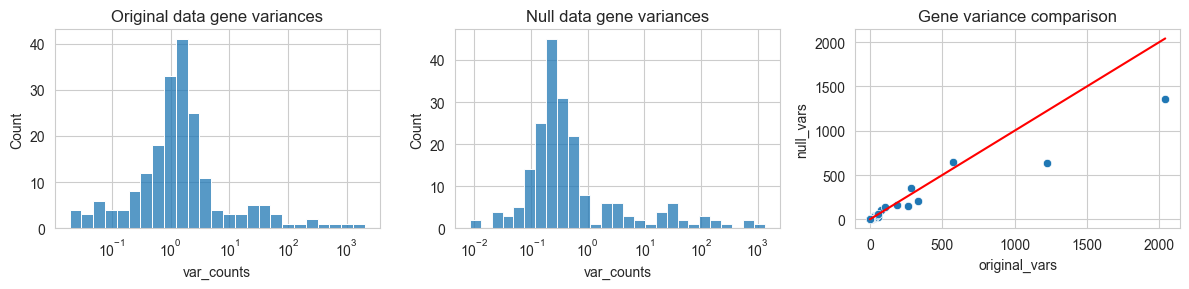

SignificanceResult(statistic=0.8700172504312609, pvalue=1.000549503352939e-62)


In [73]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene.var, x="var_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene variances")
sns.histplot(data_null_gen.var, x="var_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene variances")

var_df = pd.DataFrame({"original_vars": data_gene.var["var_counts"], "null_vars": data_null_gen.var["var_counts"]})
var_df["ratio"] = var_df["null_vars"] / var_df["original_vars"]
var_df["diff"] = var_df["null_vars"] - var_df["original_vars"]

sns.scatterplot(var_df, y="null_vars", x="original_vars", ax=ax[2])
ax[2].plot([0, np.ceil(np.max(data_gene.var["var_counts"]))], [0, np.ceil(np.max(data_gene.var["var_counts"]))], color="red")
ax[2].set_title("Gene variance comparison")
plt.tight_layout()
plt.show()
print(spearmanr(var_df["original_vars"], var_df["null_vars"]))

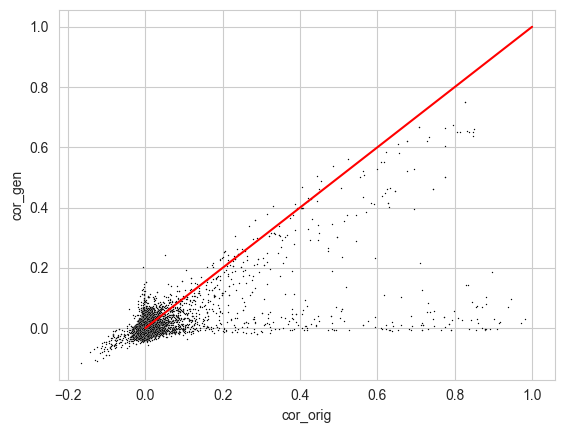

In [74]:
cor_orig = np.corrcoef(data_gene.layers["counts"].toarray().T)
cor_orig = pd.DataFrame(cor_orig, index=data_gene.var_names, columns=data_gene.var_names)

cor_gen = np.corrcoef(data_null_gen.X.T)
cor_gen = pd.DataFrame(cor_gen, index=data_gene.var_names, columns=data_gene.var_names)

# Plot only 100.000 randomly sampled correlations instaed of ~30M
rng = np.random.default_rng(1234)
all_cors = pd.DataFrame({"cor_orig": cor_orig.values.flatten(), "cor_gen": cor_gen.values.flatten(), "cor_null": cor_gen.values.flatten()})

ids = rng.choice(len(all_cors), 10000, replace=False)
all_cors_subset = all_cors.loc[ids]

sns.scatterplot(all_cors_subset[all_cors_subset['cor_orig'] < 0.99], x="cor_orig", y="cor_gen", s=1, color="black")
plt.plot([0, np.ceil(np.max(all_cors_subset['cor_orig']))], [0, np.ceil(np.max(all_cors_subset['cor_orig']))], color="red")
plt.show()

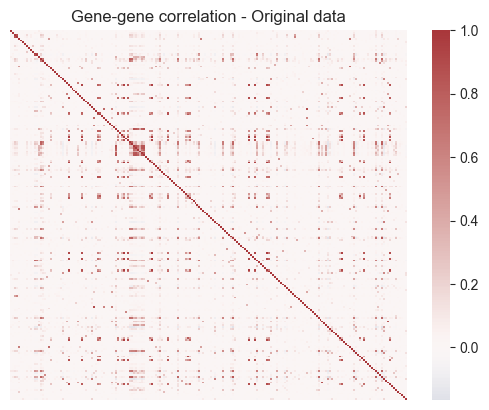

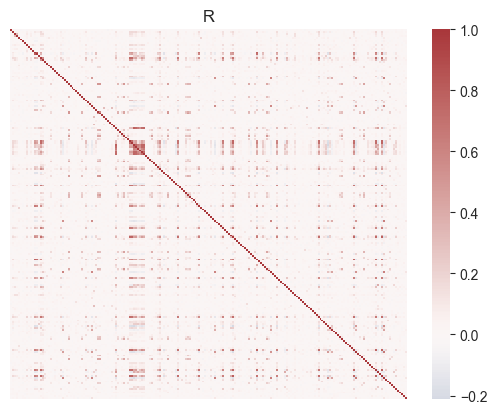

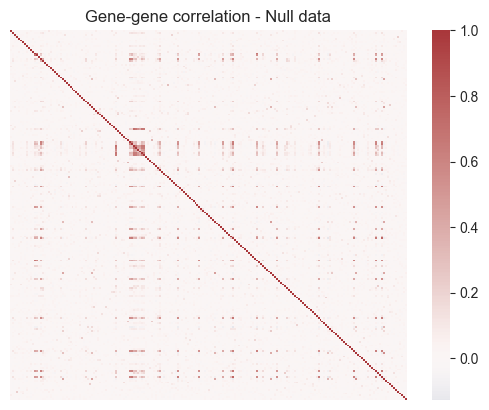

In [75]:
sns.heatmap(cor_orig,
            cmap='vlag', 
            # vmin=-0.2, vmax=0.2, 
            center=0,
            xticklabels=False, yticklabels=False)
plt.title("Gene-gene correlation - Original data")
plt.show()

sns.heatmap(R_est,
            cmap='vlag', 
            # vmin=-0.2, vmax=0.2, 
            center=0,
            xticklabels=False, yticklabels=False)
plt.title("R")
plt.show()

sns.heatmap(cor_gen,
            cmap='vlag', 
            # vmin=-0.2, vmax=0.2, 
            center=0,
            xticklabels=False, yticklabels=False)
plt.title("Gene-gene correlation - Null data")
plt.show()

### process newly generated data

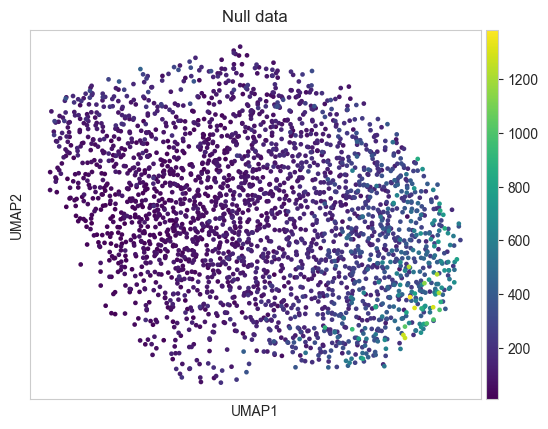

In [76]:
sc.pp.calculate_qc_metrics(data_null_gen, percent_top=None, log1p=False, inplace=True)
data_null_gen.layers["counts"] = data_null_gen.X.copy()
sc.pp.normalize_total(data_null_gen, target_sum=1e4)
sc.pp.log1p(data_null_gen)
data_null_gen.raw = data_null_gen
sc.pp.scale(data_null_gen, max_value=10)
sc.tl.pca(data_null_gen, svd_solver='arpack')
sc.pp.neighbors(data_null_gen, n_neighbors=10, n_pcs=40)
sc.tl.umap(data_null_gen)
sc.pl.umap(data_null_gen, color="total_counts", alpha=1, cmap="viridis", title="Null data")

In [89]:
res2 = 0.01
twoclust = False

while twoclust is False:
    if np.round(res2 * 10, 1)%1 == 0:
        print(res2)
    res2 += 0.01
    sc.tl.leiden(data_null_gen, resolution=res2, key_added="leiden", random_state=None)
    nclust = len(data_null_gen.obs["leiden"].unique())
    if nclust == 2:
        twoclust = True
    
    
print(f"Resolution for two clusters: {res2}")

0.09999999999999999
0.20000000000000004
Resolution for two clusters: 0.24000000000000007


In [90]:
importlib.reload(cd)
X_null_gen_0 = data_null_gen.X[data_null_gen.obs["leiden"] == "0"]
X_null_gen_1 = data_null_gen.X[data_null_gen.obs["leiden"] != "0"]

pval_null_gen = pd.DataFrame({"pval_null": ranksums(X_null_gen_0, X_null_gen_1, alternative="two-sided").pvalue}, index=data_null_gen.var.index)

clusters = data_gene.obs["leiden"].unique()

DEs_log_gen = {}
pvals_log_gen = {}
fdr = 0.05

for c in clusters:
    X_data_0 = data_gene.X[data_gene.obs["leiden"] == c]
    X_data_1 = data_gene.X[data_gene.obs["leiden"] != c]
    p_data = pd.DataFrame({"pval_data": ranksums(X_data_0, X_data_1, alternative="two-sided").pvalue}, index=data_gene.var.index)
    DE_TU, pval_TU = cd.call_de(p_data, pval_null_gen, FDR=fdr, correct=False, nlog=True)
    data_gene.var[f"pval_cluster_{c}_gen"] = pval_TU["pval_data"]
    data_gene.var[f"q_cluster_{c}_gen"] = pval_TU["q"]
    data_gene.var[f"DE_cluster_{c}_gen"] = (data_gene.var[f"q_cluster_{c}_gen"] < fdr)
    
    DEs_log_gen[c] = DE_TU
    pvals_log_gen[c] = pval_TU
    print(f"Cluster {c} - DE genes: {len(DEs_log_gen[c])}")

Cluster 0 - DE genes: 110
Cluster 2 - DE genes: 0
Cluster 1 - DE genes: 0


/Users/johannes.ostner/opt/anaconda3/envs/BacSC2/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/johannes.ostner/opt/anaconda3/envs/BacSC2/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [91]:
DEs_gen = {}
pvals_gen = {}
fdr = 0.1

for c in clusters:
    X_data_0 = data_gene.X[data_gene.obs["leiden"] == c]
    X_data_1 = data_gene.X[data_gene.obs["leiden"] != c]
    p_data = pd.DataFrame({"pval_data": ranksums(X_data_0, X_data_1, alternative="two-sided").pvalue}, index=data_gene.var.index)
    DE_TU, pval_TU = cd.call_de(p_data, pval_null_gen, FDR=fdr, correct=False, nlog=False)
    data_gene.var[f"pval_cluster_{c}_gen"] = pval_TU["pval_data"]
    data_gene.var[f"q_cluster_{c}_gen"] = pval_TU["q"]
    data_gene.var[f"DE_cluster_{c}_gen"] = (data_gene.var[f"q_cluster_{c}_gen"] < fdr)
    
    DEs_gen[c] = DE_TU
    pvals_gen[c] = pval_TU
    print(f"Cluster {c} - DE genes: {len(DEs_gen[c])}")

Cluster 0 - DE genes: 59
Cluster 2 - DE genes: 0
Cluster 1 - DE genes: 71


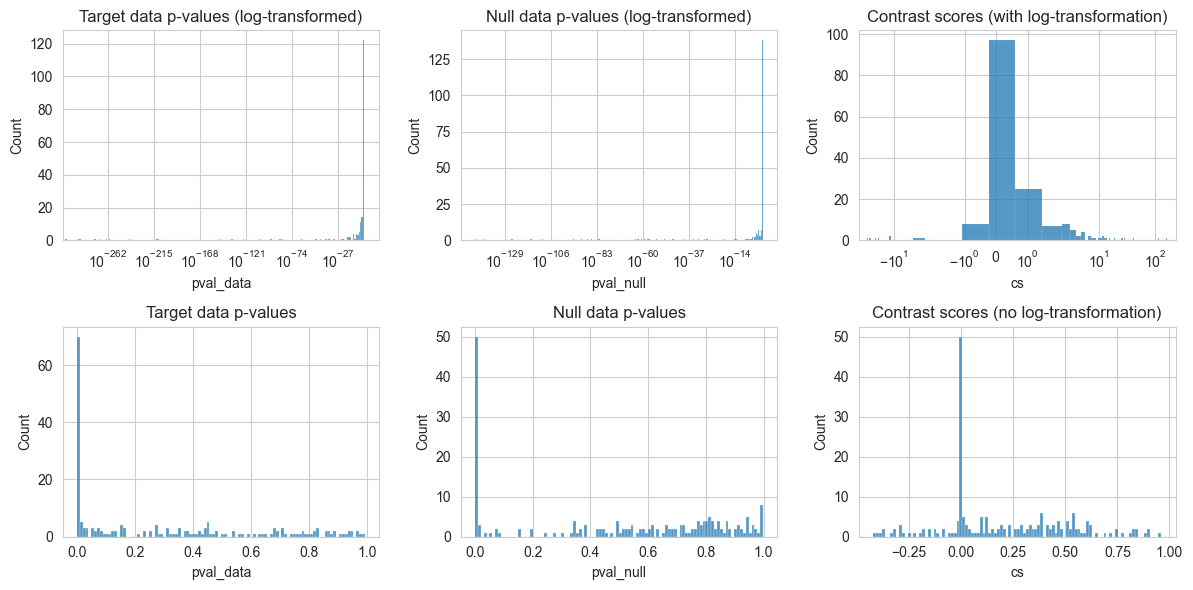

In [80]:
c = "1"

fig, ax = plt.subplots(2, 3, figsize=(12,6))
sns.histplot(pvals_log_gen[c], x="pval_data", ax=ax[0,0], log_scale=True)
ax[0,0].set_title("Target data p-values (log-transformed)")
sns.histplot(pvals_log_gen[c], x="pval_null", ax=ax[0,1], log_scale=True)
ax[0,1].set_title("Null data p-values (log-transformed)")

sns.histplot(pvals_log_gen[c], x="cs", ax=ax[0,2])
ax[0,2].set_title("Contrast scores (with log-transformation)")
ax[0,2].set(xscale="symlog")

sns.histplot(pvals_gen[c], x="pval_data", ax=ax[1,0], bins=100)
ax[1,0].set_title("Target data p-values")
sns.histplot(pvals_gen[c], x="pval_null", ax=ax[1,1], bins=100)
ax[1,1].set_title("Null data p-values")

sns.histplot(pvals_gen[c], x="cs", ax=ax[1,2], bins=100)
ax[1,2].set_title("Contrast scores (no log-transformation)")


plt.tight_layout()
plt.show()

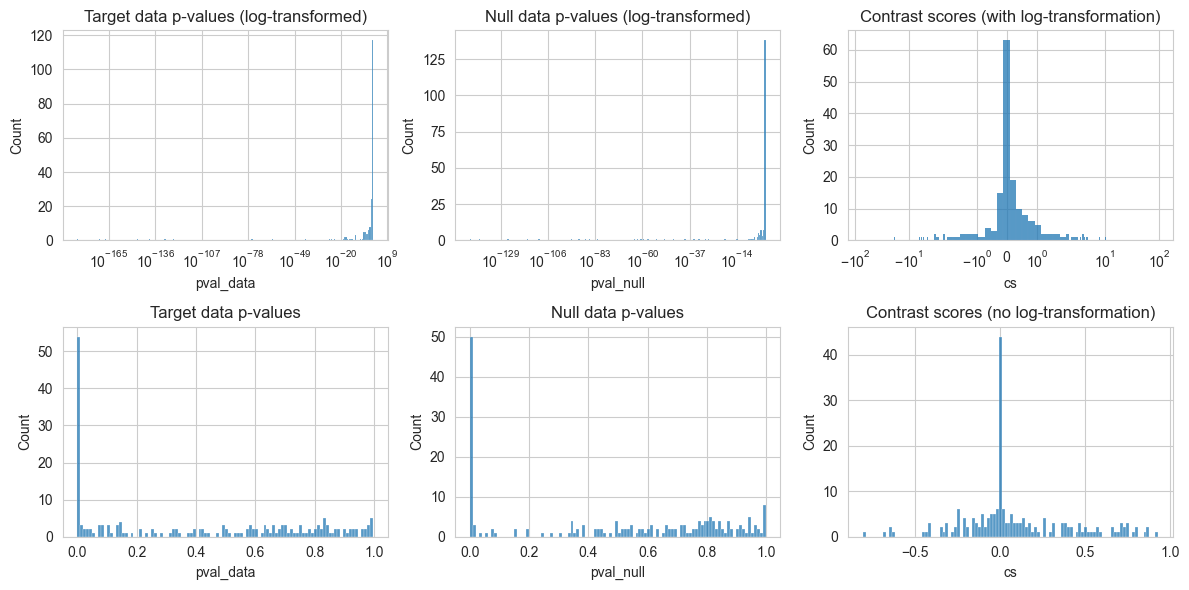

In [81]:
c = "2"

fig, ax = plt.subplots(2, 3, figsize=(12,6))
sns.histplot(pvals_log_gen[c], x="pval_data", ax=ax[0,0], log_scale=True)
ax[0,0].set_title("Target data p-values (log-transformed)")
sns.histplot(pvals_log_gen[c], x="pval_null", ax=ax[0,1], log_scale=True)
ax[0,1].set_title("Null data p-values (log-transformed)")

sns.histplot(pvals_log_gen[c], x="cs", ax=ax[0,2])
ax[0,2].set_title("Contrast scores (with log-transformation)")
ax[0,2].set(xscale="symlog")

sns.histplot(pvals_gen[c], x="pval_data", ax=ax[1,0], bins=100)
ax[1,0].set_title("Target data p-values")
sns.histplot(pvals_gen[c], x="pval_null", ax=ax[1,1], bins=100)
ax[1,1].set_title("Null data p-values")

sns.histplot(pvals_gen[c], x="cs", ax=ax[1,2], bins=100)
ax[1,2].set_title("Contrast scores (no log-transformation)")


plt.tight_layout()
plt.show()

In [85]:
pvals_log_gen["2"][:20]

,pval_data,pval_null,pval_trafo_data,pval_trafo_null,cs,q
CD79A,1.733590e-171,1.288017e-02,170.761054,1.890079,168.870975,0.500000
CD74,1.816865e-185,8.146804e-58,184.740677,57.089013,127.651664,0.500000
HLA-DQA1,2.195115e-140,1.014157e-28,139.658543,27.993895,111.664648,0.666667
TCL1A,3.298090e-76,9.111564e-03,75.481737,2.040407,73.441330,0.714286
HLA-DPB1,1.764157e-147,2.228771e-91,146.753463,90.651934,56.101528,0.714286
HLA-DMA,6.873590e-64,1.546946e-35,63.162816,34.810525,28.352292,0.714286
HLA-DRA,5.548272e-168,1.073470e-144,167.255842,143.969210,23.286632,0.714286
IGLL5,2.668617e-11,7.231207e-01,10.573714,0.140789,10.432925,0.714286
HLA-DPA1,1.260724e-125,1.073262e-116,124.899380,115.969294,8.930086,0.714286
GIMAP5,1.063916e-16,8.344358e-09,15.973093,8.078607,7.894486,0.714286


In [83]:
for c in clusters:
    print(f"cluster {c}")
    print(pvals_log_gen[c]["q"].value_counts().sort_index())
    print("")

cluster 0
q
0.029412    102
0.036036      9
0.044248      2
0.051282      4
0.058333      3
0.072000      5
0.079365      1
0.088235     10
0.109489      1
0.123188      1
0.129496      1
0.135714      1
0.140845      2
0.146853      1
0.152778      1
0.165517      1
0.168919      3
0.171053      4
0.174194      3
0.179487      1
0.186335      5
0.190184      2
0.213415      1
0.218182      1
1.000000     35
Name: count, dtype: int64

cluster 2
q
0.500000     2
0.666667     1
0.714286    60
0.718750     1
0.723077     1
0.731343     2
0.735294     1
0.739130     1
0.742857     1
0.779221     7
0.794872     1
0.827160     3
0.833333     3
0.844444     6
0.858696     2
0.881720     1
0.884211     2
0.886598     2
0.887755     1
0.888889     1
0.896226     7
1.000000    94
Name: count, dtype: int64

cluster 1
q
0.052632    19
0.095238     2
0.112150    86
0.118182     3
0.123894     3
0.129310     3
0.130081     7
0.169355     1
0.174603     2
0.187500     2
0.189394     4
0.191176     4


In [92]:
data_gene.var

,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,highly_variable_rank,means,variances,...,var_counts,pval_cluster_0_gen,q_cluster_0_gen,DE_cluster_0_gen,pval_cluster_2_gen,q_cluster_2_gen,DE_cluster_2_gen,pval_cluster_1_gen,q_cluster_1_gen,DE_cluster_1_gen
TNFRSF9,11,False,11,0.007961,99.583017,21.0,True,113.0,0.007961,0.027620,...,0.027609,8.737929e-01,1.000000,False,0.885611,1.000000,False,9.472878e-01,1.000000,False
SDHB,581,False,571,0.315011,78.354814,831.0,True,61.0,0.315011,3.336073,...,3.334809,1.489900e-07,0.210843,False,0.338135,1.000000,False,4.632065e-11,0.260000,False
C1QA,36,False,36,0.043215,98.635330,114.0,True,18.0,0.043215,0.339429,...,0.339300,1.682525e-01,0.047619,True,0.637772,0.420290,False,5.807573e-02,0.035714,True
C1QB,17,False,17,0.028810,99.355572,76.0,True,21.0,0.028810,0.269932,...,0.269830,5.177321e-01,0.068966,True,0.824057,0.480000,False,3.730952e-01,0.044444,True
STMN1,196,False,190,0.115997,92.797574,306.0,True,109.0,0.115997,0.807169,...,0.806863,3.113330e-02,0.047619,True,0.711651,0.420290,False,7.308530e-03,0.035714,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ADSL,285,False,279,0.142532,89.423806,376.0,True,163.0,0.142532,1.209863,...,1.209404,7.437580e-01,1.000000,False,0.131222,0.472222,False,4.255012e-01,1.000000,False
PACSIN2,121,False,120,0.067854,95.451099,179.0,True,153.0,0.067854,0.666232,...,0.665980,2.459854e-01,0.115942,False,0.645181,1.000000,False,9.997866e-02,0.054545,True
DSCR3,171,False,164,0.100076,93.783169,264.0,True,32.0,0.100076,1.235336,...,1.234867,8.297780e-01,1.000000,False,0.827954,1.000000,False,6.845020e-01,1.000000,False
C21orf33,289,False,282,0.145565,89.310083,384.0,True,175.0,0.145565,1.355367,...,1.354853,9.270650e-01,1.000000,False,0.751916,1.000000,False,8.876853e-01,1.000000,False


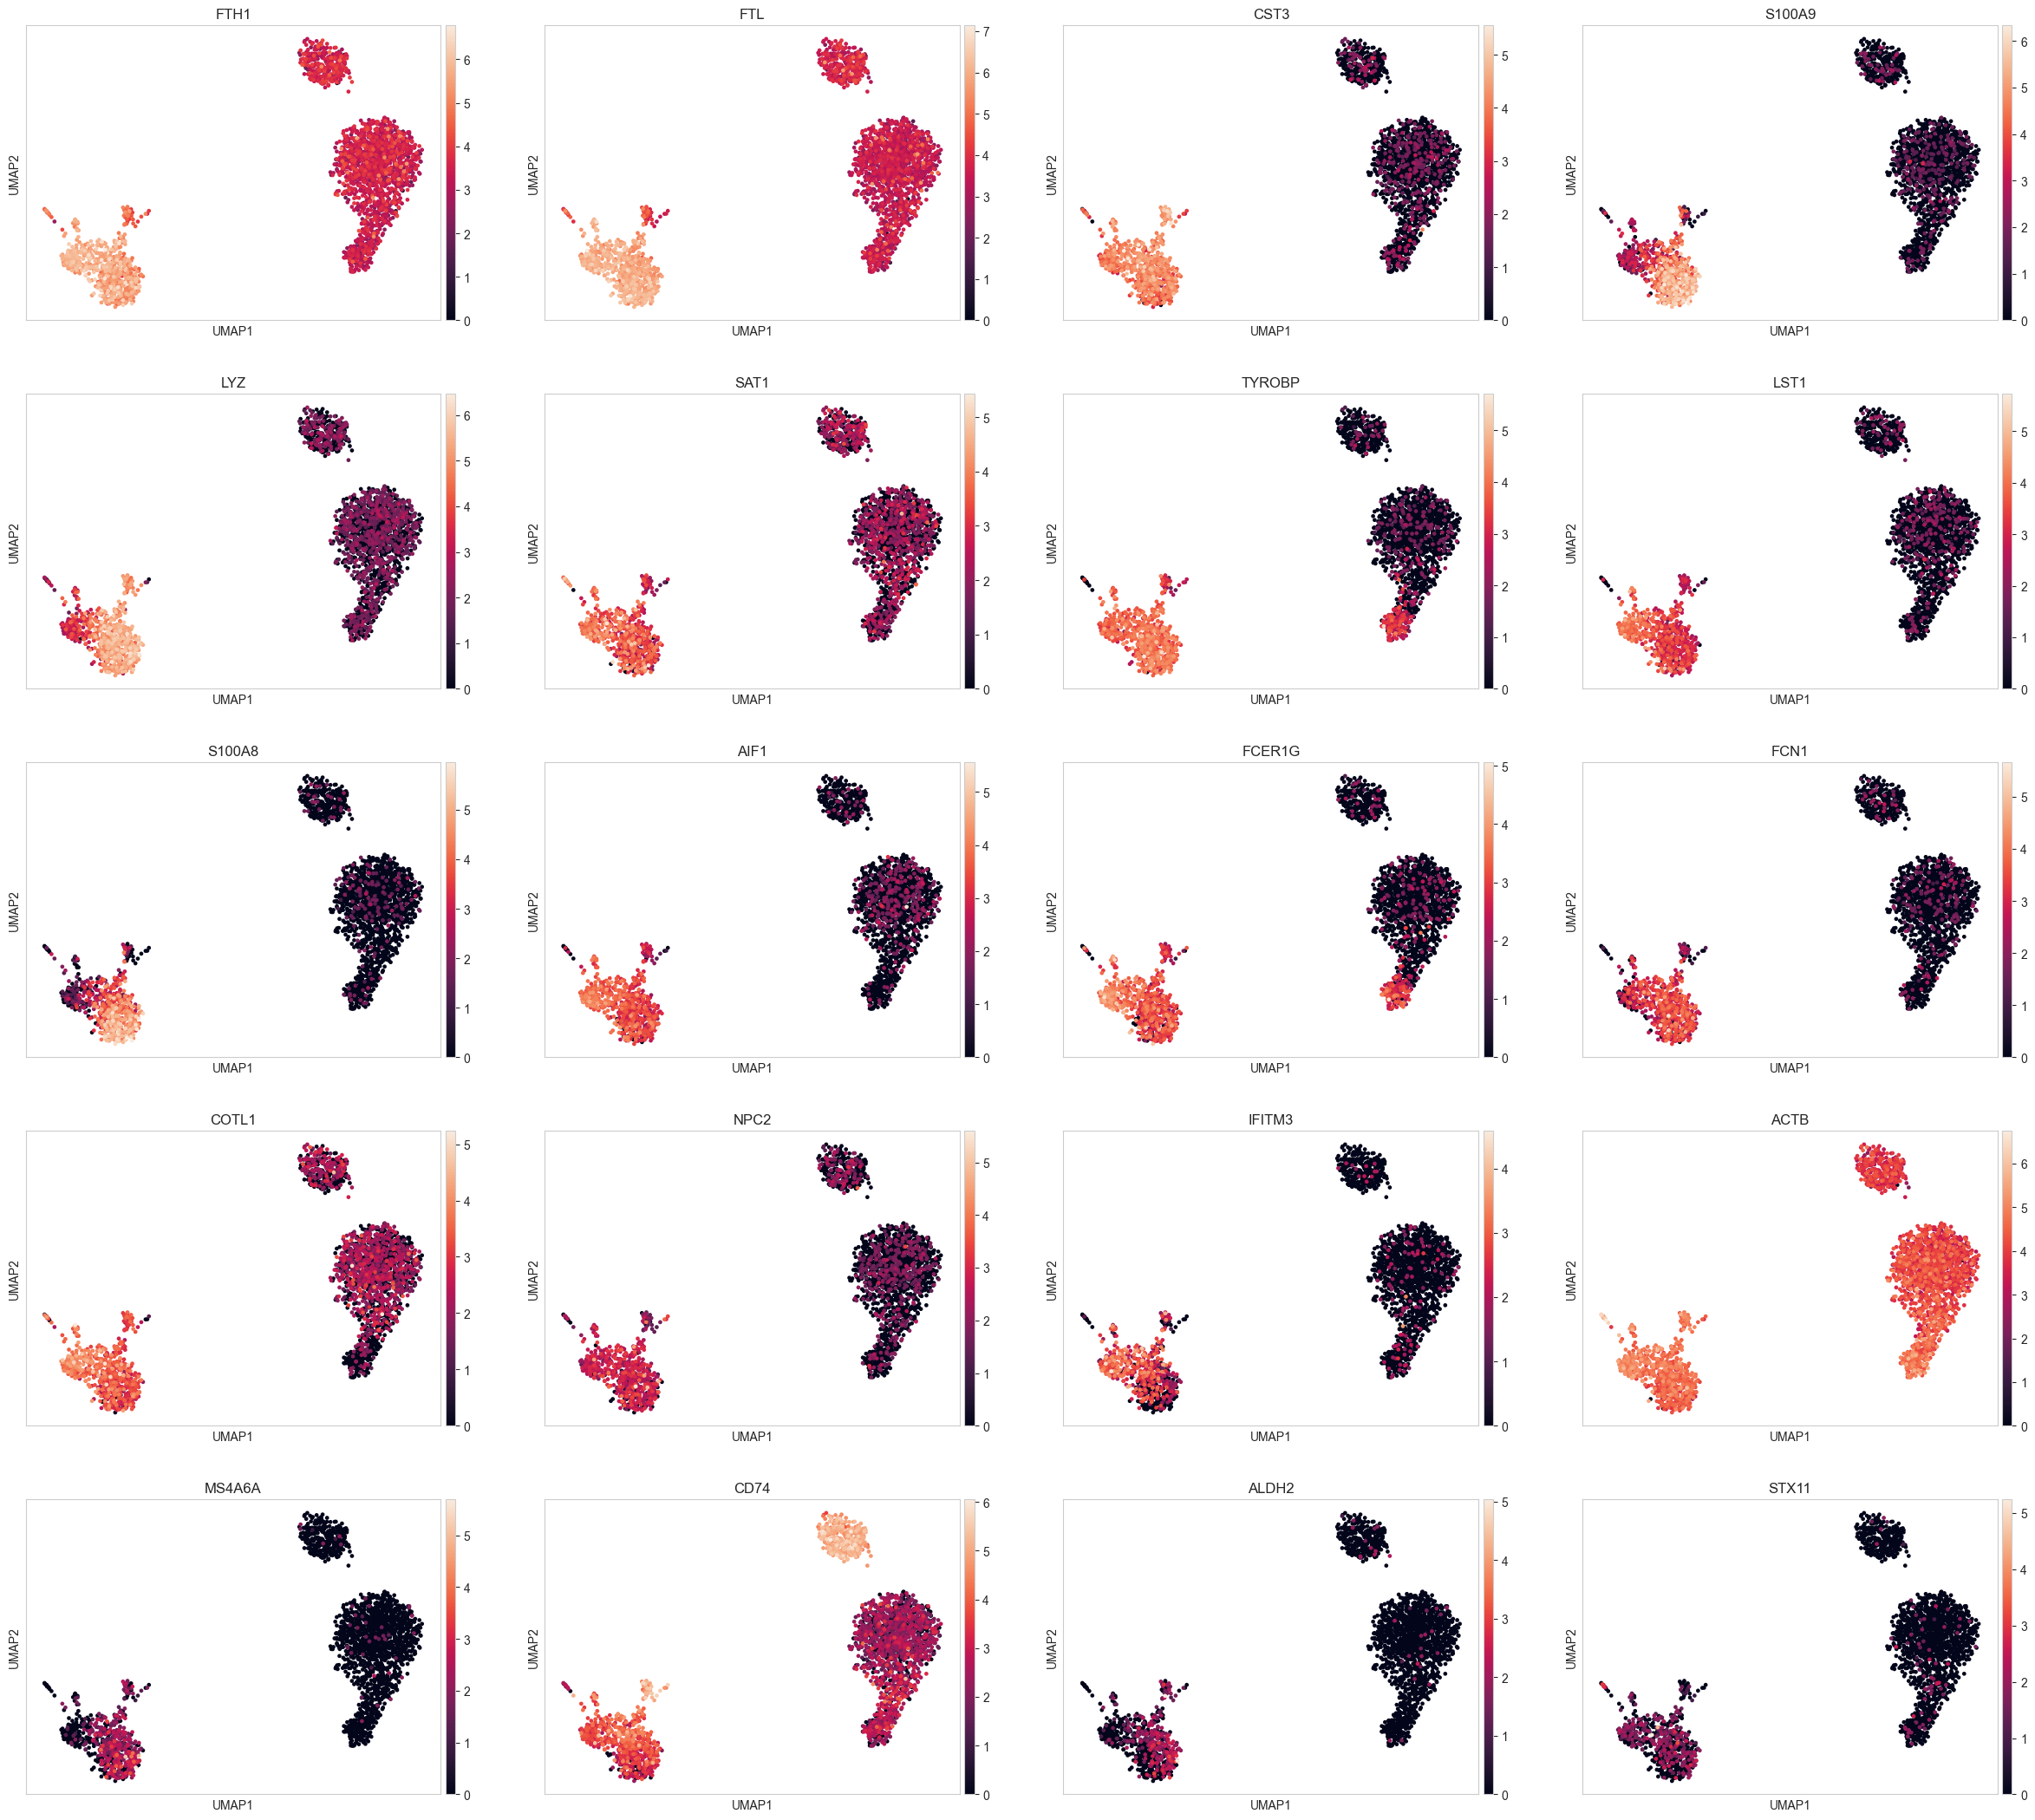

In [24]:
sc.pl.umap(data_gene, color=DEs_log_gen["1"].index.tolist()[:20])


/Users/johannes.ostner/opt/anaconda3/envs/BacSC2/lib/python3.11/site-packages/scanpy/plotting/_tools/__init__.py:1170: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  _ax = sns.violinplot(
/Users/johannes.ostner/opt/anaconda3/envs/BacSC2/lib/python3.11/site-packages/scanpy/plotting/_tools/__init__.py:1183: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  _ax = sns.stripplot(
/Users/johannes.ostner/opt/anaconda3/envs/BacSC2/lib/python3.11/site-packages/scanpy/plotting/_tools/__init__.py:1199: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation='vertical')


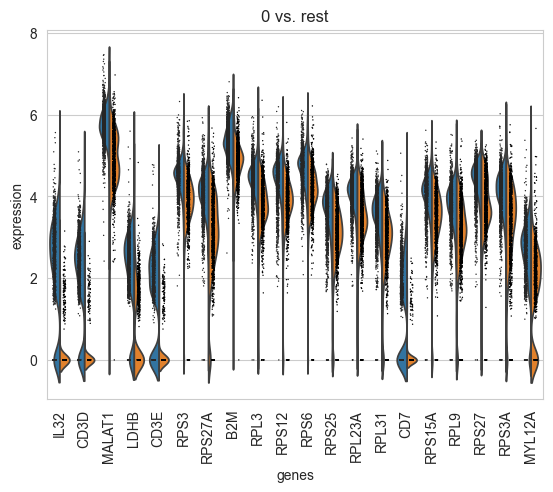

/Users/johannes.ostner/opt/anaconda3/envs/BacSC2/lib/python3.11/site-packages/scanpy/plotting/_tools/__init__.py:1170: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  _ax = sns.violinplot(
/Users/johannes.ostner/opt/anaconda3/envs/BacSC2/lib/python3.11/site-packages/scanpy/plotting/_tools/__init__.py:1183: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  _ax = sns.stripplot(
/Users/johannes.ostner/opt/anaconda3/envs/BacSC2/lib/python3.11/site-packages/scanpy/plotting/_tools/__init__.py:1199: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation='vertical')


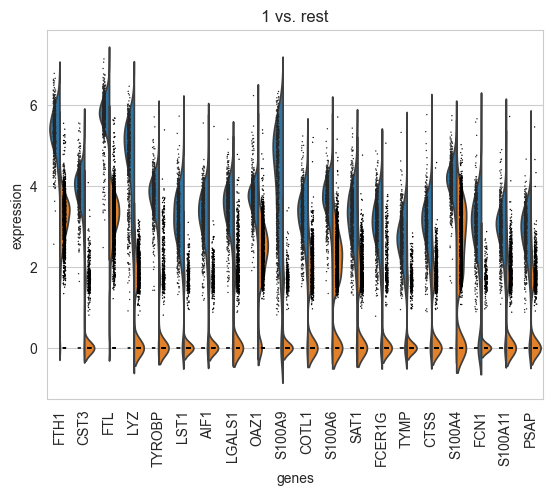

/Users/johannes.ostner/opt/anaconda3/envs/BacSC2/lib/python3.11/site-packages/scanpy/plotting/_tools/__init__.py:1170: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  _ax = sns.violinplot(
/Users/johannes.ostner/opt/anaconda3/envs/BacSC2/lib/python3.11/site-packages/scanpy/plotting/_tools/__init__.py:1183: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  _ax = sns.stripplot(
/Users/johannes.ostner/opt/anaconda3/envs/BacSC2/lib/python3.11/site-packages/scanpy/plotting/_tools/__init__.py:1199: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation='vertical')


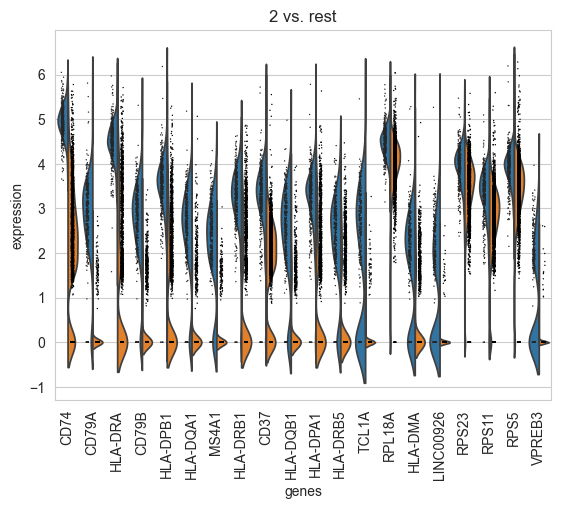

In [25]:
sc.pl.rank_genes_groups_violin(data_gene, n_genes=20)